# How many beach cleanup events will happen in a region over the next year?

Given the beach cleanup data and a region, we want to predict how many beach cleanup events will happen in that region for the next year.
First, let's load in the data.

In [1]:
import pandas as pd
import sqlite3

new = pd.read_csv('../data/cleanups.csv')[['Year', 'COUNTRY']]
old = pd.DataFrame({'Year': pd.to_datetime(pd.read_csv('../data/new-cleanups.csv')['Cleanup Date']).dt.year, 'COUNTRY': pd.read_csv('../data/new-cleanups.csv')['Country']})
cleanups = pd.concat([new, old]).reset_index()
cleanups

/Users/abhinavmadahar/Documents/ocean_plastic_pollution/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,21,22,23,24,34,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/abhinavmadahar/Documents/ocean_plastic_pollution/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,index,Year,COUNTRY
0,0,2015.0,United States
1,1,2015.0,United States
2,2,2015.0,United States
3,3,2015.0,United States
4,4,2015.0,United States
...,...,...,...
102751,48363,2020.0,United States
102752,48364,2020.0,NaN
102753,48365,2020.0,NaN
102754,48366,2020.0,NaN


Restricting ourselves to a single country, let's see if we can predict the number of beach cleanups in the next year by taking the linear regression of the past 2 years.
Note that some countries have very little data if you go back too far; for example, we have almost no data for Malaysia before 2018.

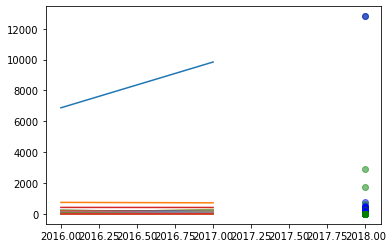

In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

year_to_forecast = 2018
accuracies = []

for country, number_of_cleanups in cleanups.loc[:, 'COUNTRY'].value_counts().items():
    try:
        x = cleanups.loc[(cleanups.loc[:, 'Year'] < year_to_forecast) & (cleanups.loc[:, 'Year'] >= year_to_forecast - 2) & (cleanups.loc[:, 'COUNTRY'] == country)]
        y = len(cleanups.loc[(cleanups.loc[:, 'Year'] == year_to_forecast) & (cleanups.loc[:, 'COUNTRY'] == country)])
        plt.plot(x.loc[:, 'Year'].value_counts().keys(), x.loc[:, 'Year'].value_counts().values)
        plt.scatter(year_to_forecast, y, color='Green', alpha=0.5);
        x1, x2 = x.loc[:, 'Year'].value_counts()
        prediction = x1 + (x1-x2)
        plt.scatter(year_to_forecast, prediction, color='Blue', alpha=0.5)
        accuracy = 100 * (1 - abs((prediction - y) / y))
        accuracies.append((accuracy, country))
    except:
        pass

Now, let's plot the accuracies.

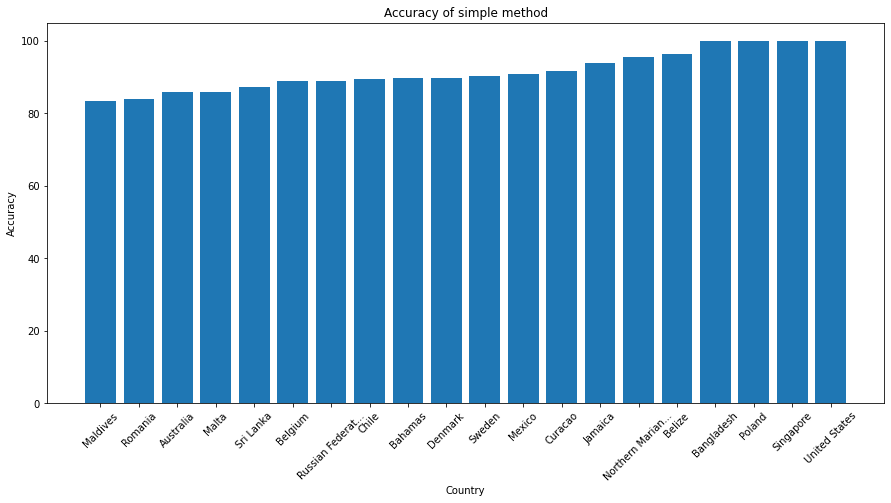

In [3]:
accuracies = sorted(accuracies)
best = accuracies[-20:]
performances, countries = list(zip(*best))
countries = [country[:15] + ('...' if len(country) > 15 else '') for country in countries]
plt.figure(figsize=(15, 7))
plt.title('Accuracy of simple method')
plt.bar(countries, performances)
plt.xlabel('Country')
plt.ylabel('Accuracy')
plt.xticks(rotation=45);

Let's see a map of accuracies by country.

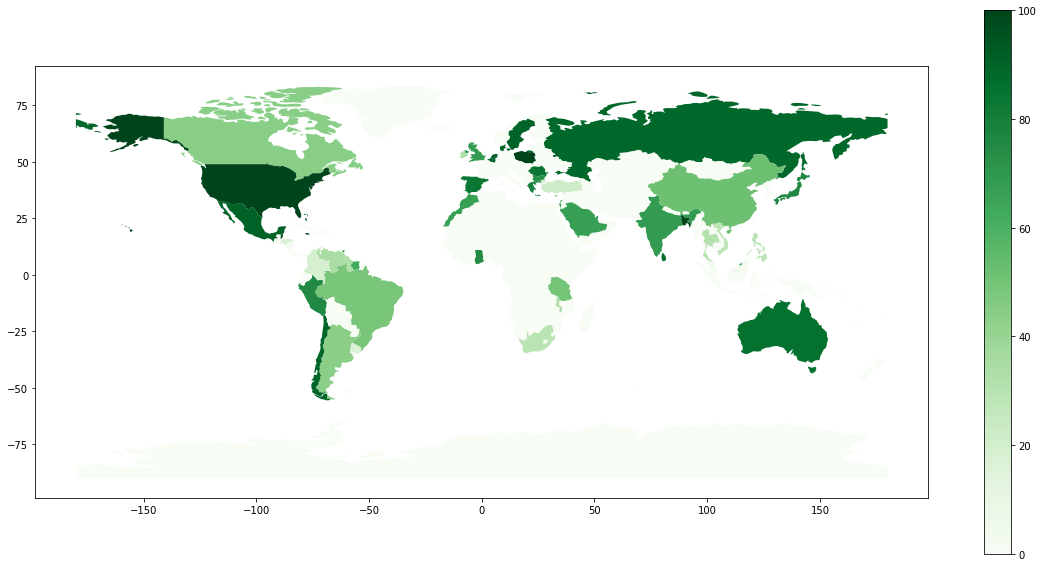

In [4]:
import pycountry
import geopandas

accuracy_of = {c:a for a, c in accuracies}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')).set_index('iso_a3')
world.loc[:, 'Accuracy'] = [0 for _ in range(len(world))]

for country, accuracy in accuracy_of.items():
    try:
        abbreviation = pycountry.countries.search_fuzzy(country)[0].alpha_3
        if abbreviation in world.index and accuracy > 0:
            world.loc[abbreviation, 'Accuracy'] = accuracy
    except:
        pass

world.plot(column='Accuracy', legend=True, figsize=(20, 10), cmap='Greens');